**CIFAR**-10 Dataset



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === VAE WITH CLASSIFIER ===
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # -> [B, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # -> [B, 64, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # -> [B, 128, 4, 4]
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # -> [B, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> [B, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # -> [B, 3, 32, 32]
            nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)
        return self.fc_mu(h_flat), self.fc_logvar(h_flat)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits
# === RECONSTRUCTION CLASSIFIER ===
class ReconClassifier(nn.Module):
    def __init__(self, input_dim=3072, num_classes=10):
        super(ReconClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return MSE + KLD + alpha * CE

# === LOAD MNIST ===
print("Load CIFAR... ", end="")
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print("done.")

# === INIT MODELS ===
vae_model = ConvVAE().to(device)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
recon_clf = ReconClassifier(input_dim=3072).to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

# === TRAIN VAE ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 12

for epoch in range(epochs):
    start_time = time.time()
    vae_model.train()
    train_loss = 0
    correct, total = 0, 0

    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        data = data.to(device)
        target = target.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar, logits = vae_model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target)
        loss.backward()
        vae_optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    vae_model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Eval]"):
            data = data.to(device)
            target = target.to(device)
            recon, mu, logvar, logits = vae_model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%, "
          f"Time: {epoch_time:.2f}s")

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss", marker='o')
  plt.plot(test_losses, label="Test Loss", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss per Epoch")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy", marker='o')
  plt.plot(test_accuracies, label="Test Accuracy", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy per Epoch")
  plt.legend()
  plt.tight_layout()
  plt.show()

# === PLOT TRAINING VAE CURVE - LOSSES AND ACCURACIES ===
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# === VAE RECONSTRUCTIONS & BOTTLENECK CLASSIFIER PREDICTIONS ===
vae_model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    data = images[:8].to(device)
    recon, _, _, logits = vae_model(data)
    preds = logits.argmax(dim=1).cpu().numpy()
    images = images[:8].cpu()
    recon = recon.view(-1, 3, 32, 32).cpu()

    plt.figure(figsize=(16, 5))
    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f"Orig:{labels[i].item()}")
        plt.axis('off')

        plt.subplot(2, 8, i + 9)
        plt.imshow(np.transpose(recon[i], (1, 2, 0)))
        plt.title(f"Recon:{preds[i]}")
        plt.axis('off')

    plt.suptitle("Original (Top), Reconstructed (Bottom)")
    plt.tight_layout()
    plt.show()

# === TRAIN RECONSTRUCTION CLASSIFIER ON ORIGINAL IMAGES ===
clf_epochs = 12
clf_train_losses, clf_test_losses = [], []
clf_train_accuracies, clf_test_accuracies = [], []
for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.view(data.size(0), -1).to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    clf_train_losses.append(clf_loss / len(train_loader.dataset))
    clf_train_accuracies.append(100. * correct / total)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

    # === EVALUATE CLASSIFIER ON RECONSTRUCTED IMAGES ===
    recon_clf.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            recon, _, _, _ = vae_model(data)
            logits = recon_clf(recon.view(recon.size(0), -1))
            loss = F.cross_entropy(logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    recon_acc = 100. * correct / total
    clf_test_losses.append(clf_loss / len(test_loader.dataset))
    clf_test_accuracies.append(100. * correct / total)
    print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

# === PLOT TRAINING CURVE FOR CLASSIFIER - LOSSES AND ACCURACIES ===
plot_training_curves(clf_train_losses, clf_test_losses, clf_train_accuracies, clf_test_accuracies)

# === PLOT COMPARISON ===
plt.figure(figsize=(8, 5))
plt.bar(['Latent Classification', 'Reconstruction Classification'], [test_accuracies[-1], recon_acc], color=['skyblue', 'salmon'])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Latent vs Reconstructed Image Classification")
plt.ylim(0, 100)
for i, v in enumerate([test_accuracies[-1], recon_acc]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

Using device: cuda
Load CIFAR... done.


Epoch 1/12 [Train]:  71%|███████   | 276/391 [00:07<00:03, 35.54it/s]


KeyboardInterrupt: 

Using device: cuda
Load CIFAR... done.
Epoch 1/12, Train Loss: 27.2597, Test Loss: 10.5221, Train Acc: 10.49%, Test Acc: 10.96%
Epoch 2/12, Train Loss: 13.9990, Test Loss: 9.1993, Train Acc: 10.24%, Test Acc: 10.38%
Epoch 3/12, Train Loss: 12.9526, Test Loss: 7.9774, Train Acc: 10.19%, Test Acc: 10.27%
Epoch 4/12, Train Loss: 12.1963, Test Loss: 7.3980, Train Acc: 10.37%, Test Acc: 10.07%
Epoch 5/12, Train Loss: 11.7534, Test Loss: 7.4045, Train Acc: 10.32%, Test Acc: 10.48%
Epoch 6/12, Train Loss: 11.2838, Test Loss: 6.8658, Train Acc: 10.09%, Test Acc: 10.81%
Epoch 7/12, Train Loss: 11.0316, Test Loss: 6.6769, Train Acc: 10.26%, Test Acc: 10.42%
Epoch 8/12, Train Loss: 10.9078, Test Loss: 6.5457, Train Acc: 10.13%, Test Acc: 9.78%
Epoch 9/12, Train Loss: 10.7233, Test Loss: 6.6950, Train Acc: 10.44%, Test Acc: 9.99%
Epoch 10/12, Train Loss: 10.6501, Test Loss: 6.7098, Train Acc: 10.22%, Test Acc: 9.79%
Epoch 11/12, Train Loss: 10.5648, Test Loss: 6.6931, Train Acc: 10.34%, Test Acc: 

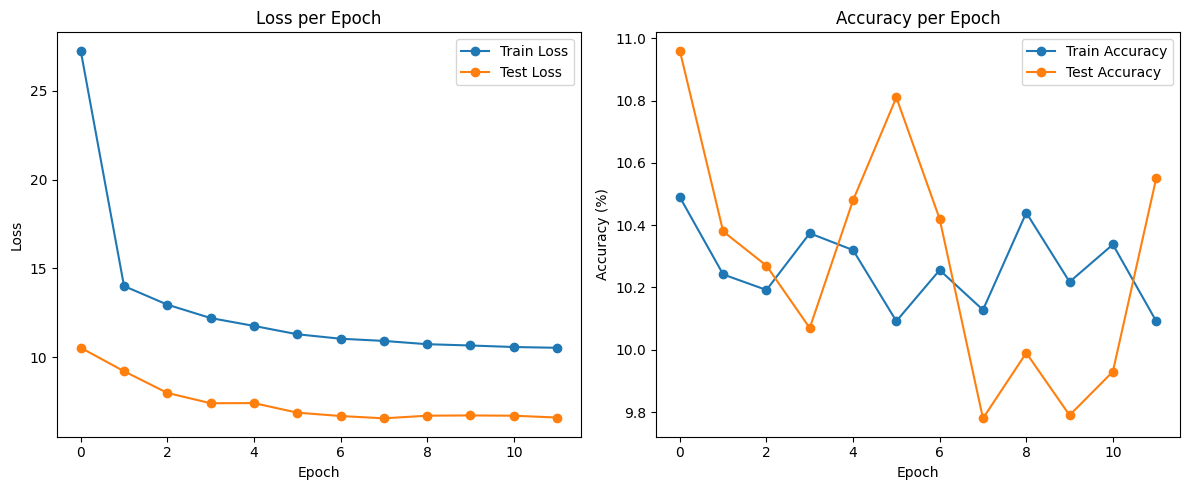

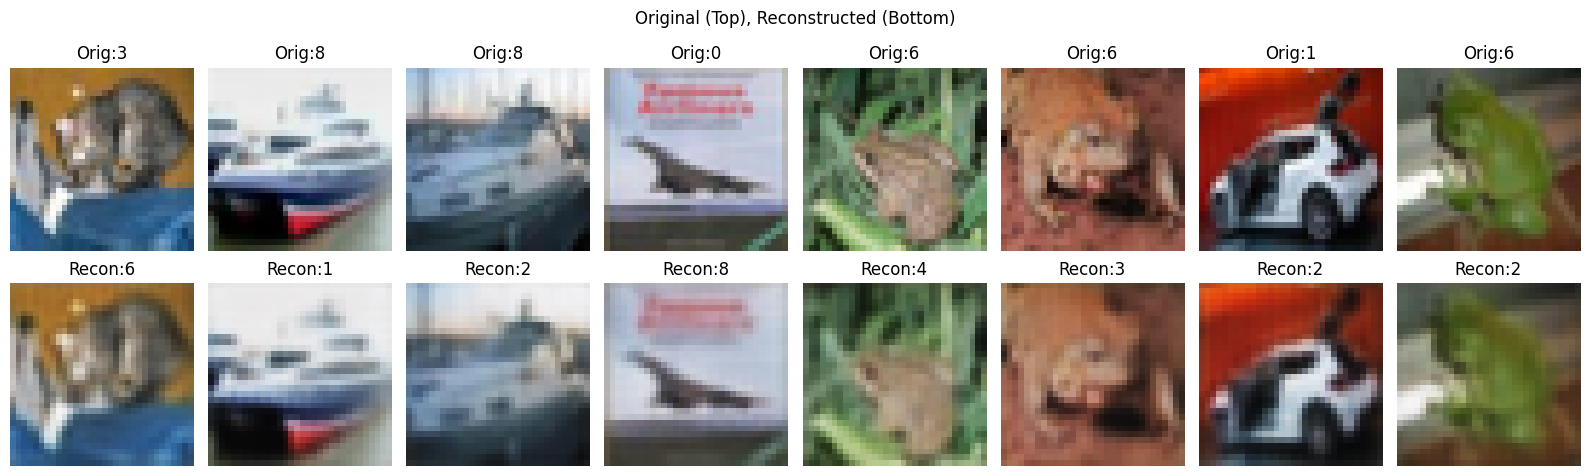

ReconClassifier Epoch 1, Loss: 729.88, Train Acc: 32.41%
Accuracy on Reconstructed Images (Separate Classifier): 38.17%
ReconClassifier Epoch 2, Loss: 653.52, Train Acc: 40.29%
Accuracy on Reconstructed Images (Separate Classifier): 42.59%
ReconClassifier Epoch 3, Loss: 619.28, Train Acc: 43.38%
Accuracy on Reconstructed Images (Separate Classifier): 44.07%
ReconClassifier Epoch 4, Loss: 596.62, Train Acc: 45.61%
Accuracy on Reconstructed Images (Separate Classifier): 45.89%
ReconClassifier Epoch 5, Loss: 583.51, Train Acc: 47.06%
Accuracy on Reconstructed Images (Separate Classifier): 47.06%
ReconClassifier Epoch 6, Loss: 569.33, Train Acc: 48.03%
Accuracy on Reconstructed Images (Separate Classifier): 47.13%
ReconClassifier Epoch 7, Loss: 558.46, Train Acc: 49.00%
Accuracy on Reconstructed Images (Separate Classifier): 47.99%
ReconClassifier Epoch 8, Loss: 546.66, Train Acc: 50.16%
Accuracy on Reconstructed Images (Separate Classifier): 48.23%
ReconClassifier Epoch 9, Loss: 538.34, T

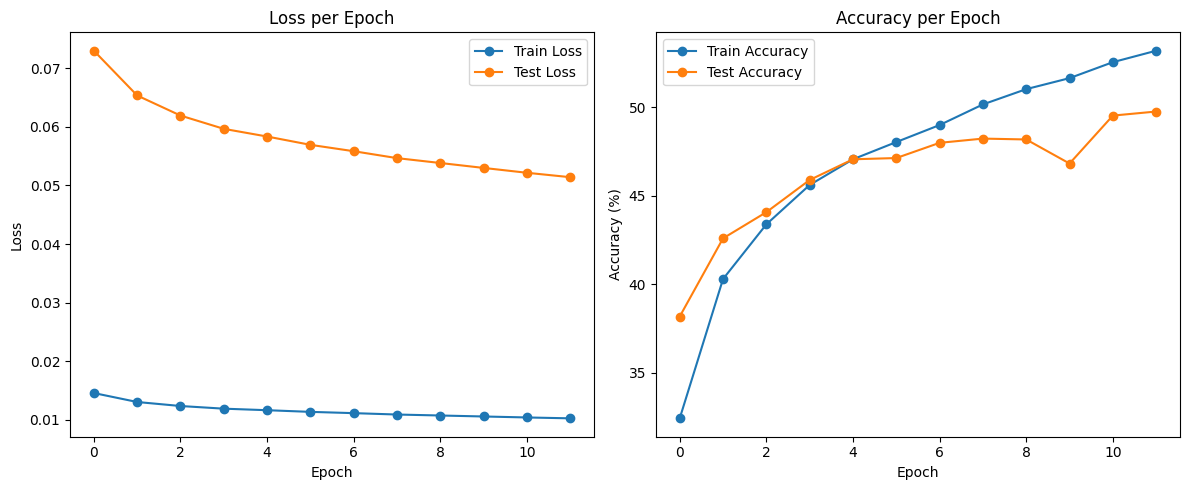

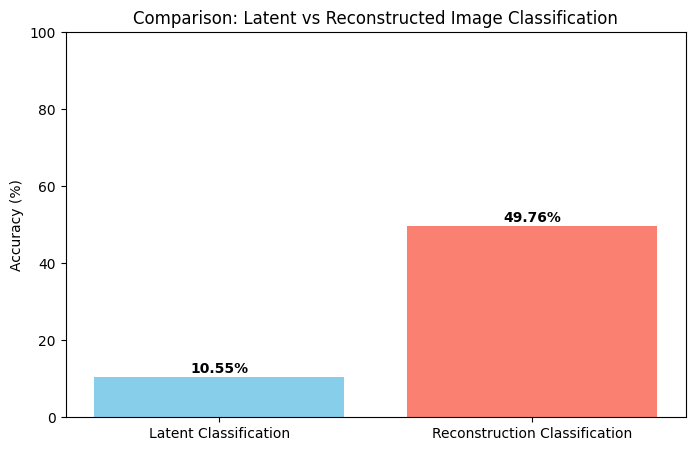

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
ALPHA=1.0

# === VAE WITH CLASSIFIER ===
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # ---------- Encoder ----------
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),        # [B, 32, 32, 32]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                        # [B, 32, 16, 16]
            nn.Dropout(0.3)
        )

        self.skip = nn.Conv2d(32, 32, 3, padding=1)  # skip connection: [B, 32, 16, 16]

        self.enc2 = nn.Sequential(
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                        # [B, 32, 8, 8]
            nn.Dropout(0.3)
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),        # [B, 64, 8, 8]
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)                         # [B, 64, 4, 4]
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

        # ---------- Decoder ----------
        self.fc_decode = nn.Linear(latent_dim, 64 * 4 * 4)

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # [B, 64, 8, 8]
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 16, 16]
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.dec3 = nn.Conv2d(32, 32, 3, padding=1)  # [B, 32, 16, 16] (refined)

        self.final = nn.Sequential(
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),  # [B, 3, 32, 32]
            nn.Sigmoid()  # constrain output to [0, 1]
        )
        self.classifier = nn.Linear(latent_dim, num_classes)


    def encode(self, x):
        x = self.enc1(x)
        skip = self.skip(x)           # [B, 32, 16, 16]
        x = self.enc2(skip)           # [B, 32, 8, 8]
        x = self.enc3(x)              # [B, 64, 4, 4]
        x = self.flatten(x)           # [B, 1024]
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar, skip

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skip):
        x = self.fc_decode(z).view(-1, 64, 4, 4)
        x = self.dec1(x)     # [B, 64, 8, 8]
        x = self.dec2(x)     # [B, 32, 16, 16]
        x = self.dec3(x)     # [B, 32, 16, 16]
        x = x + skip         # skip connection
        x = self.final(x)    # [B, 3, 32, 32]
        return x

    def forward(self, x):
        mu, logvar, skip = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, skip)
        logits = self.classifier(z)  # classification output
        return x_hat, mu, logvar, logits
# === RECONSTRUCTION CLASSIFIER ===
class ReconClassifier(nn.Module):
    def __init__(self, input_dim=3072, num_classes=10):
        super(ReconClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=ALPHA):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = F.cross_entropy(logits, labels, reduction='sum')
    return recon_loss + kl_loss + alpha * class_loss
# === LOAD MNIST ===
print("Load CIFAR... ", end="")
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print("done.")

# === INIT MODELS ===
vae_model = ConvVAE(latent_dim=128, num_classes=10).to(device)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
recon_clf = ReconClassifier(input_dim=3072).to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

# === TRAIN VAE ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 12

for epoch in range(epochs):
    vae_model.train()
    train_loss = 0
    correct, total = 0, 0
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar, logits = vae_model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target, alpha=ALPHA)
        loss.backward()
        vae_optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    vae_model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            recon, mu, logvar, logits = vae_model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss", marker='o')
  plt.plot(test_losses, label="Test Loss", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss per Epoch")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy", marker='o')
  plt.plot(test_accuracies, label="Test Accuracy", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy per Epoch")
  plt.legend()
  plt.tight_layout()
  plt.show()

# === PLOT TRAINING VAE CURVE - LOSSES AND ACCURACIES ===
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# === VAE RECONSTRUCTIONS & BOTTLENECK CLASSIFIER PREDICTIONS ===
vae_model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    data = images[:8].to(device)
    recon, _, _, logits = vae_model(data)
    preds = logits.argmax(dim=1).cpu().numpy()
    images = images[:8].cpu()
    recon = recon.view(-1, 3, 32, 32).cpu()

    plt.figure(figsize=(16, 5))
    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f"Orig:{labels[i].item()}")
        plt.axis('off')

        plt.subplot(2, 8, i + 9)
        plt.imshow(np.transpose(recon[i], (1, 2, 0)))
        plt.title(f"Recon:{preds[i]}")
        plt.axis('off')

    plt.suptitle("Original (Top), Reconstructed (Bottom)")
    plt.tight_layout()
    plt.show()

# === TRAIN RECONSTRUCTION CLASSIFIER ON ORIGINAL IMAGES ===
clf_epochs = 12
clf_train_losses, clf_test_losses = [], []
clf_train_accuracies, clf_test_accuracies = [], []
for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data.view(data.size(0), -1))
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    clf_train_losses.append(clf_loss / len(train_loader.dataset))
    clf_train_accuracies.append(100. * correct / total)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

    # === EVALUATE CLASSIFIER ON RECONSTRUCTED IMAGES ===
    recon_clf.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            recon, _, _, _ = vae_model(data)
            logits = recon_clf(recon.view(recon.size(0), -1))
            loss = F.cross_entropy(logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    recon_acc = 100. * correct / total
    clf_test_losses.append(clf_loss / len(test_loader.dataset))
    clf_test_accuracies.append(100. * correct / total)
    print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

# === PLOT TRAINING CURVE FOR CLASSIFIER - LOSSES AND ACCURACIES ===
plot_training_curves(clf_train_losses, clf_test_losses, clf_train_accuracies, clf_test_accuracies)

# === PLOT COMPARISON ===
plt.figure(figsize=(8, 5))
plt.bar(['Latent Classification', 'Reconstruction Classification'], [test_accuracies[-1], recon_acc], color=['skyblue', 'salmon'])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Latent vs Reconstructed Image Classification")
plt.ylim(0, 100)
for i, v in enumerate([test_accuracies[-1], recon_acc]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()